## 导入数据

In [1]:
import pandas as pd
import numpy as np
import pickle
import random
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

# npois = 29071
# nspus = 179778

npois = 29924
nusers = 200000
# nspus = 195244

In [51]:
datapath = "../data/SMP新数据-20210607-20210702/"
savepath = "../data/processed/"

d_session = pd.read_csv(datapath+"orders_poi_session.txt", sep='\t')
d_train = pd.read_csv(datapath+"orders_train.txt", encoding="utf-8", sep='\t')
d_test = pd.read_csv(datapath + "orders_test_poi.txt", encoding="utf-8", sep='\t')
d_user = pd.read_csv(datapath+"users.txt", encoding="utf-8", sep='\t')
d_poi = pd.read_csv(datapath+"pois.txt", encoding="utf-8", sep='\t')
d_spu = pd.read_csv(datapath+"spus.txt", encoding="utf-8", sep='\t')

In [ ]:
# 读取处理后的数据

# 联合 orders_train 和 orders_test 的订单表，对于缺失数据做 encoding，对于以下在 test 中缺失的列，用 -1 填充
_train_only_cols = ['wm_poi_id', 'order_price_interval', 'order_scene_name']
order_df = pickle.load(open(savepath+'orders_all.pkl', 'rb'))
# 编码 users 表，并 
# 1. 基于 session 提出 avg_clicks_len	count_orders	avg_duplicate	poi_in_session 特征
# 2. 基于 order_df，统计
user_df = pickle.load(open(savepath+'users_basic2.pkl', 'rb'))

### 数据概况

In [6]:
d_train.head()

,user_id,wm_order_id,wm_poi_id,aor_id,order_price_interval,order_timestamp,ord_period_name,order_scene_name,aoi_id,takedlvr_aoi_type_name,dt
0,178557,0,2334,6,<29,1623061539,3,0,NaN,未知,20210607
1,175118,1,3315,0,<29,1623032193,1,1,0.0,0,20210607
2,36208,2,2168,0,<29,1623036350,1,0,1.0,0,20210607
3,102798,3,3071,0,"[29,36)",1623071723,4,0,2.0,0,20210607
4,73712,4,2902,0,"[49,65)",1623020472,0,2,3.0,1,20210607


In [5]:
d_session.head()

,wm_order_id,clicks,dt
0,1103,2168#1884,20210607
1,24171,NaN,20210607
2,27913,1371#1494#3518,20210607
3,24875,1901#1901#1901#1901#2398,20210607
4,23149,NaN,20210607


In [29]:
# session_df = d_session.merge(d_train, on=['wm_order_id', 'dt'])

In [9]:
d_session.shape, d_train.shape, d_test.shape
# test 的订单号好像不是完全连续的，数量不符

((1303169, 3), (1071873, 11), (168546, 8))

In [12]:
d_session.wm_order_id.max(), d_train.wm_order_id.max(), d_test.wm_order_id.max()

(1363763, 1071872, 1282847)

In [10]:
1071873+168546

1240419

## 1. 处理 order 表

编码类别特征、填充缺失值……

In [52]:
d_train_row = d_train.copy()
d_train.head()

,user_id,wm_order_id,wm_poi_id,aor_id,order_price_interval,order_timestamp,ord_period_name,order_scene_name,aoi_id,takedlvr_aoi_type_name,dt
0,178557,0,2334,6,<29,1623061539,3,0,NaN,未知,20210607
1,175118,1,3315,0,<29,1623032193,1,1,0.0,0,20210607
2,36208,2,2168,0,<29,1623036350,1,0,1.0,0,20210607
3,102798,3,3071,0,"[29,36)",1623071723,4,0,2.0,0,20210607
4,73712,4,2902,0,"[49,65)",1623020472,0,2,3.0,1,20210607


In [53]:
# 1. 价格
price2id = {
    '<29': 1,
    '[29,36)': 2,
    '[36,49)': 3,
    '[49,65)': 4,
    '>=65': 5,
    '未知': 0
}
# user表中有未知
d_train['order_price_interval'] = [price2id[p] for p in d_train['order_price_interval'].values]

In [60]:
d_test['order_price_interval'] = -1

In [56]:
# 2. 商家号
d_test['wm_poi_id'] = -1

In [58]:
# 3. 下单场景（eg 娱乐场所、商场）

scene2id = {str(i):i for i in range(9)}
scene2id['未知'] = 9
d_train['order_scene_name'].value_counts()

0     529986
1     177313
未知     89595
6      63992
2      57433
4      54771
5      37533
3      26970
7      21301
8      12979
Name: order_scene_name, dtype: int64

In [59]:
d_train['order_scene_name'] = [scene2id[s] for s in d_train['order_scene_name'].values]
d_test['order_scene_name'] = -1

In [70]:
# ==================== 拼接 train 和 test
# d_test.shape
order_df = pd.concat([d_train, d_test])
order_df.dtypes

user_id                     int64
wm_order_id                 int64
wm_poi_id                   int64
aor_id                      int64
order_price_interval        int64
order_timestamp             int64
ord_period_name             int64
order_scene_name            int64
aoi_id                    float64
takedlvr_aoi_type_name     object
dt                          int64
dtype: object

In [74]:
order_df.loc[order_df['wm_poi_id']==-1].isna().sum(axis=0)
# NaN all 61559, test 7404

user_id                      0
wm_order_id                  0
wm_poi_id                    0
aor_id                       0
order_price_interval         0
order_timestamp              0
ord_period_name              0
order_scene_name             0
aoi_id                    7404
takedlvr_aoi_type_name       0
dt                           0
dtype: int64

In [82]:
# 4. aoi_id 收餐地址兴趣面 
order_df['aoi_id'].max()    # 3669
order_df['aoi_id'].fillna(order_df['aoi_id'].max() + 1, inplace=True)
order_df['aoi_id'] = order_df['aoi_id'].astype(int)

In [86]:
# 5. 收餐地址类型（eg 办公楼）takedlvr_aoi_type_name
order_df['takedlvr_aoi_type_name'].value_counts()
# test 56821, 64585
takedlvr_aoi2id = {str(i): i for i in range(12)}
takedlvr_aoi2id['未知'] = 12
order_df['takedlvr_aoi_type_name'] = [takedlvr_aoi2id[a] for a in order_df['takedlvr_aoi_type_name'].values]

In [88]:
order_df.dtypes
order_df.head()

,user_id,wm_order_id,wm_poi_id,aor_id,order_price_interval,order_timestamp,ord_period_name,order_scene_name,aoi_id,takedlvr_aoi_type_name,dt
0,178557,0,2334,6,1,1623061539,3,0,3670,12,20210607
1,175118,1,3315,0,1,1623032193,1,1,0,0,20210607
2,36208,2,2168,0,1,1623036350,1,0,1,0,20210607
3,102798,3,3071,0,2,1623071723,4,0,2,0,20210607
4,73712,4,2902,0,4,1623020472,0,2,3,1,20210607


In [89]:
pickle.dump(order_df, open(savepath+'orders_all.pkl', 'wb'))

## 2. 用户特征工程

### 2.1 用户基本特征 users.txt

统计 user 表信息，编码 订单均价 等类别特征

In [13]:
d_user.head()

,user_id,avg_pay_amt,avg_pay_amt_weekdays,avg_pay_amt_weekends
0,0,"[36,49)","[36,49)","[36,49)"
1,1,"[29,36)","[29,36)",<29
2,2,>=65,>=65,>=65
3,3,<29,<29,<29
4,4,"[29,36)","[29,36)",未知


In [90]:
d_user.avg_pay_amt_weekends.unique()

array(['[36,49)', '<29', '>=65', '未知', '[49,65)', '[29,36)'], dtype=object)

/Users/easonshi/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26410 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/easonshi/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 30693 missing from current font.
  font.set_text(s, 0.0, flags=flags)


<Figure size 432x288 with 0 Axes>

/Users/easonshi/miniconda3/lib/python3.9/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 26410 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/easonshi/miniconda3/lib/python3.9/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 30693 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/easonshi/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 26410 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/easonshi/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 30693 missing from current font.
  font.set_text(s, 0, flags=flags)


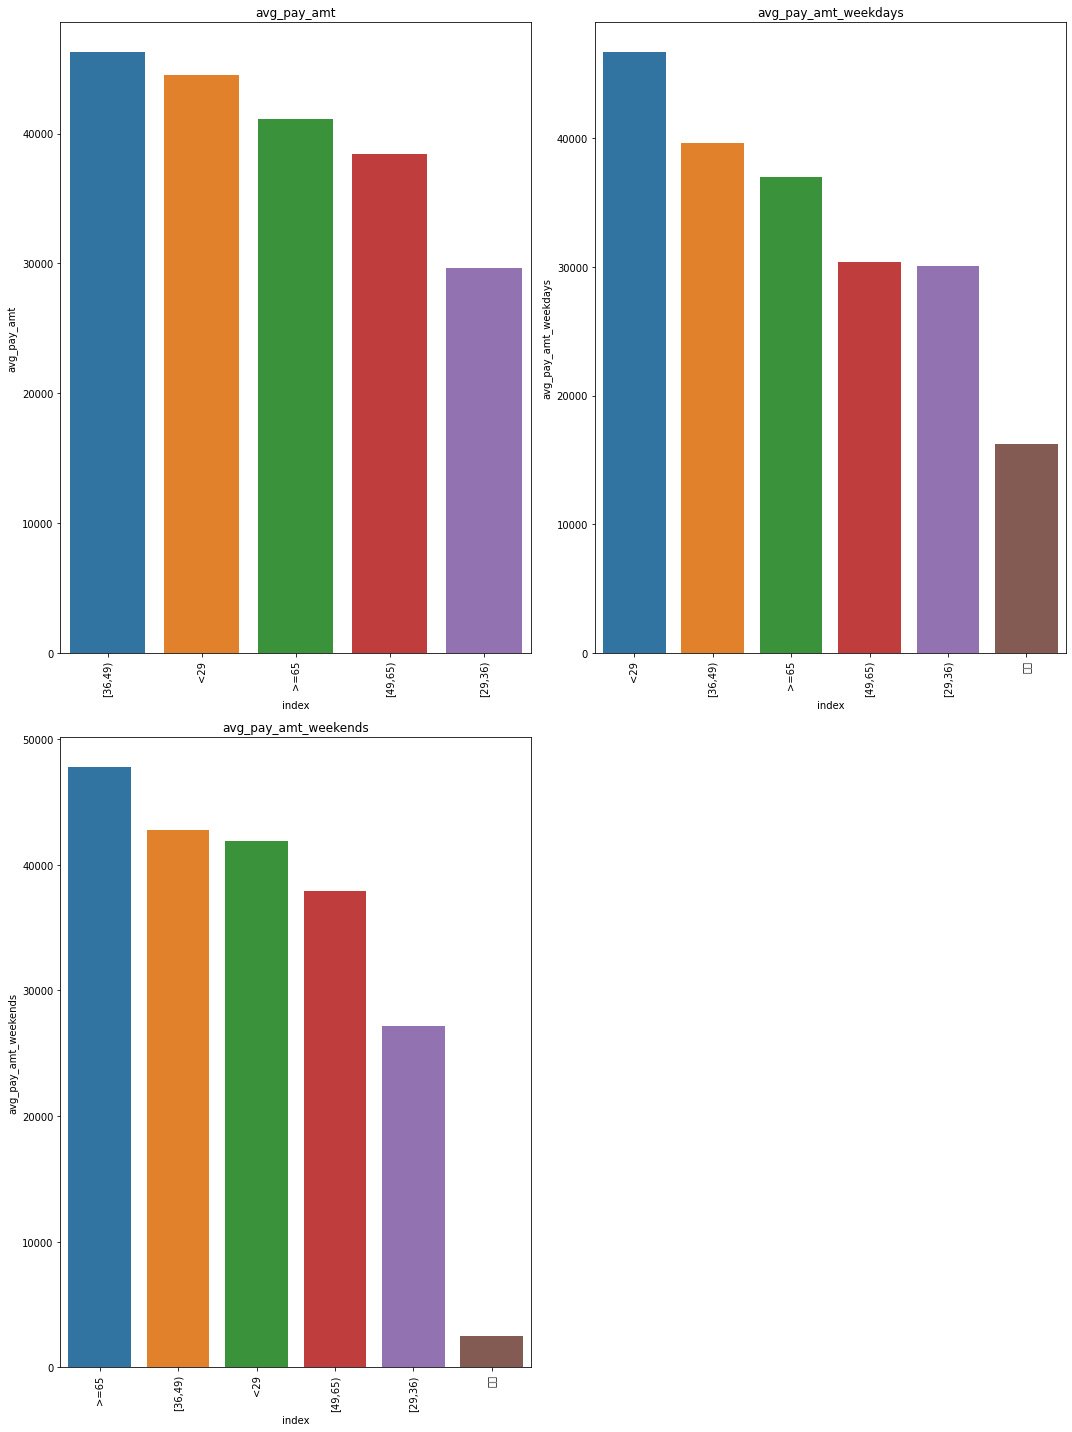

In [22]:
plt.figure()
plt.figure(figsize=(15, 20))
i = 1
for col in ['avg_pay_amt', 'avg_pay_amt_weekdays', 'avg_pay_amt_weekends']:
    plot_envs = plt.subplot(2, 2, i)
    i += 1
    v = d_user[col].value_counts().reset_index()[:10]
    fig = sns.barplot(x=v['index'], y=v[col])
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()

In [91]:
# le = LabelEncoder()

# 编码用户基本特征，「未知」直接作为一种类别
user_df = d_user.copy()
_user_basic_cols = ['avg_pay_amt', 'avg_pay_amt_weekdays', 'avg_pay_amt_weekends']
for c in _user_basic_cols:
    # user_df[c] = le.fit_transform(user_df[c])
    user_df[c] = [price2id[p] for p in user_df[c]]

user_df.head()

,user_id,avg_pay_amt,avg_pay_amt_weekdays,avg_pay_amt_weekends
0,0,3,3,3
1,1,2,2,1
2,2,5,5,5
3,3,1,1,1
4,4,2,2,0


In [94]:
# pickle.dump(user_df, open(savepath+'users_basic.pkl', 'wb'))
d_user.head()

,user_id,avg_pay_amt,avg_pay_amt_weekdays,avg_pay_amt_weekends
0,0,"[36,49)","[36,49)","[36,49)"
1,1,"[29,36)","[29,36)",<29
2,2,>=65,>=65,>=65
3,3,<29,<29,<29
4,4,"[29,36)","[29,36)",未知


### 2.2 联合 session 表

sessin + (train/test)，探究用户订单过程中的序列特征

- 平均点击长度
- 是否有重复/重复比例
- 订单数量

In [95]:
# d_train.columns, d_test.columns

In [16]:
# 连接 train 和 test 表
# _train_only_cols = ['wm_poi_id', 'order_price_interval', 'order_scene_name']
# d_train_ = d_train.drop(columns=_train_only_cols)
# d_order = d_train_.append(d_test)
# d_order.shape

(1240419, 8)

In [96]:
session_df = d_session.merge(order_df, on=['wm_order_id', 'dt'])
session_df.shape
# d_session 1303169，右连接，保留有用的 session

(1240419, 12)

In [99]:
session_df.dtypes

wm_order_id                int64
clicks                    object
dt                         int64
user_id                    int64
wm_poi_id                  int64
aor_id                     int64
order_price_interval       int64
order_timestamp            int64
ord_period_name            int64
order_scene_name           int64
aoi_id                     int64
takedlvr_aoi_type_name     int64
dtype: object

In [98]:
# 将 clicks 转化为 list
session_df['clicks'] = session_df['clicks'].apply(lambda x: [int(i) for i in x.split('#')] if not pd.isnull(x) else [])

In [100]:
session_df['clicks_len'] = session_df['clicks'].apply(len)

In [101]:
session_df['is_view_dup'] = session_df['clicks'].apply(lambda x: len(x) != len(set(x)))

In [102]:
session_df.clicks_len = session_df.clicks_len.astype(np.int)
session_df.clicks_len.describe()

count    1.240419e+06
mean     3.849823e+00
std      7.782676e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+00
max      1.950000e+02
Name: clicks_len, dtype: float64

In [103]:
# 提取用户 1. session 平均点击长度；2. 订单数量；3. 重复的比例
session_group = session_df.groupby(by=['user_id'])
user_df = pickle.load(open(savepath+'users_basic.pkl', 'rb'))
user_df['avg_clicks_len'] = session_group['clicks_len'].mean()
user_df['count_orders'] = session_group['clicks'].count()
user_df['avg_duplicate'] = session_group['is_view_dup'].mean()
user_df.tail()

,user_id,avg_pay_amt,avg_pay_amt_weekdays,avg_pay_amt_weekends,avg_clicks_len,count_orders,avg_duplicate
199995,199995,5,5,5,6.500000,8,0.500000
199996,199996,3,3,3,3.000000,9,0.222222
199997,199997,1,1,1,0.000000,9,0.000000
199998,199998,2,3,1,7.909091,11,0.454545
199999,199999,3,0,4,0.857143,7,0.000000


In [23]:
# def f_count_duplies(df):
#     df['view_dup'] = df['clicks'].apply(lambda x: len(x) != len(set(x)))
#     # df['view_dup'] = len(df['clicks']) != len(set(df['clicks']))
#     return df['view_dup'].sum() / len(df)
# session_group.apply(f_count_duplies)

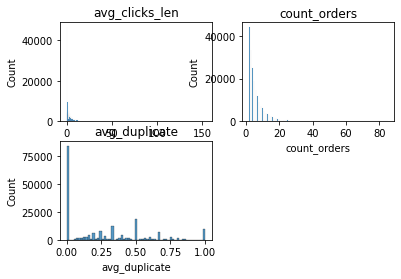

In [104]:
plt.figure()
i = 1
for col in ['avg_clicks_len', 'count_orders', 'avg_duplicate']:
    plt.subplot(2, 2, i)
    i += 1
    sns.histplot(user_df[col])
    plt.title(col)
plt.show()

In [105]:
user_df.describe()

,user_id,avg_pay_amt,avg_pay_amt_weekdays,avg_pay_amt_weekends,avg_clicks_len,count_orders,avg_duplicate
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,99999.500000,3.009480,2.660805,3.074255,3.552158,6.202095,0.263010
std,57735.171256,1.433088,1.610014,1.492462,5.560599,5.314640,0.294377
min,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,49999.750000,2.000000,1.000000,2.000000,0.300000,3.000000,0.000000
50%,99999.500000,3.000000,3.000000,3.000000,1.833333,4.000000,0.200000
75%,149999.250000,4.000000,4.000000,4.000000,4.500000,8.000000,0.500000
max,199999.000000,5.000000,5.000000,5.000000,153.000000,85.000000,1.000000


In [57]:
(user_df.avg_clicks_len > 100).sum(), (user_df.avg_clicks_len == 0).sum()

(20, 45612)

In [106]:
# pickle.dump(user_df, open(savepath+'users_basic2.pkl', 'wb'))

#### 2.2.2 

- 下单商铺是否出现在 session 中

这部分仅连接 train 表

In [107]:
session_df = d_session.merge(d_train, on=['wm_order_id', 'dt'])
session_df.shape
# d_session 1071873

(1071873, 12)

In [108]:
# 将 clicks 转化为 list
session_df['clicks'] = session_df['clicks'].apply(lambda x: [int(i) for i in x.split('#')] if not pd.isnull(x) else [])

In [109]:
session_df['poi_in_session'] = session_df.apply(lambda x: x['wm_poi_id'] in x['clicks'], axis=1) 
# need to set axis=1


In [110]:
session_df.poi_in_session.describe()

count     1071873
unique          2
top         False
freq       971857
Name: poi_in_session, dtype: object

In [112]:
# session_df

In [113]:
# user_df = pickle.load(open(savepath+'users_basic2.pkl', 'rb'))
user_df['poi_in_session'] = session_df.groupby('user_id')['poi_in_session'].mean()
user_df.head()

,user_id,avg_pay_amt,avg_pay_amt_weekdays,avg_pay_amt_weekends,avg_clicks_len,count_orders,avg_duplicate,poi_in_session
0,0,3,3,3,0.391304,23,0.000000,0.000000
1,1,2,2,1,1.857143,7,0.428571,0.000000
2,2,5,5,5,5.375000,8,0.750000,0.142857
3,3,1,1,1,0.800000,5,0.000000,0.000000
4,4,2,2,0,2.666667,3,0.666667,0.000000


In [114]:
pickle.dump(user_df, open(savepath+'users_basic2.pkl', 'wb'))

### 2.3 综合 order 信息

  - 蜂窝、价格区间、时间、时段、下单场景（测试集缺）、收餐地址、类别
  - 基本统计特征：下单数量、
  - 下单数量前十的商铺（wide）
  - Ts/dt 区分工作日与否

In [159]:
order_df = pickle.load(open(savepath+'orders_all.pkl', 'rb'))
user_df = pickle.load(open(savepath+'users_basic2.pkl', 'rb'))
user_df_raw = user_df
order_df.head()

,user_id,wm_order_id,wm_poi_id,aor_id,order_price_interval,order_timestamp,ord_period_name,order_scene_name,aoi_id,takedlvr_aoi_type_name,dt
0,178557,0,2334,6,1,1623061539,3,0,3670,12,20210607
1,175118,1,3315,0,1,1623032193,1,1,0,0,20210607
2,36208,2,2168,0,1,1623036350,1,0,1,0,20210607
3,102798,3,3071,0,2,1623071723,4,0,2,0,20210607
4,73712,4,2902,0,4,1623020472,0,2,3,1,20210607


In [130]:
# 1. 商家
order_train = order_df[order_df['wm_poi_id']!=-1]

In [134]:
user_pois = order_train.groupby('user_id')['wm_poi_id'].apply(lambda x: list(x.values))
user_pois.head()

<bound method NDFrame.head of user_id
0         [3263, 2972, 809, 2972, 806, 1738, 2183, 474, ...
1                [3374, 2624, 2624, 2624, 2398, 2725, 2986]
2                  [570, 2417, 1848, 2856, 3231, 3116, 618]
3                            [3386, 1751, 1957, 1957, 1957]
4                                        [2119, 2292, 1860]
                                ...                        
199995        [728, 1640, 2858, 70, 2858, 2337, 1640, 2337]
199996            [3133, 636, 1832, 3487, 1832, 1832, 2611]
199997         [3085, 259, 2060, 259, 2749, 2934, 90, 2060]
199998    [2273, 3374, 2309, 600, 2309, 288, 996, 1196, ...
199999           [3392, 3392, 3392, 3048, 1071, 3392, 3392]
Name: wm_poi_id, Length: 200000, dtype: object>

In [139]:
_diff = user_pois.apply(len) - user_pois.apply(lambda x: len(set(x)))
_diff.describe()

count    200000.000000
mean          1.544925
std           2.570707
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          65.000000
Name: wm_poi_id, dtype: float64

In [142]:
user_pois.apply(len).describe()
user_pois.apply(lambda x: len(set(x))).describe()

count    200000.000000
mean          3.814440
std           2.869881
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          44.000000
Name: wm_poi_id, dtype: float64

用户平均选用商铺数量为 5.35， 而平均选用的不同商铺数量为 3.81；说明重复购买的行为还是很普遍的，首选商家可作为用户的特征

In [147]:
user_pois_top5 = user_pois.apply(lambda x: Counter(x).most_common(5))
user_most_visit_count = user_pois_top5.apply(lambda x: x[0][1])
user_most_visit_count.describe()

count    200000.000000
mean          2.090850
std           1.575645
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max          44.000000
Name: wm_poi_id, dtype: float64

In [160]:
user_df['top1_visit'] = user_most_visit_count

In [149]:
user_pois_top5_list = user_pois_top5.apply(lambda x: [a[0] for a in x])
user_pois_top5_list[:5]

user_id
0      [2972, 956, 2971, 3263, 809]
1    [2624, 3374, 2398, 2725, 2986]
2     [570, 2417, 1848, 2856, 3231]
3                [1957, 3386, 1751]
4                [2119, 2292, 1860]
Name: wm_poi_id, dtype: object

In [155]:
user_pois_top5_list[:20]

user_id
0       [2972, 956, 2971, 3263, 809]
1     [2624, 3374, 2398, 2725, 2986]
2      [570, 2417, 1848, 2856, 3231]
3                 [1957, 3386, 1751]
4                 [2119, 2292, 1860]
5             [564, 112, 2947, 1109]
6                        [557, 3320]
7                        [596, 1168]
8                       [3484, 1937]
9       [1077, 112, 1911, 1679, 851]
10                      [1432, 1811]
11                [2171, 2019, 3125]
12     [244, 1458, 3307, 2998, 3304]
13     [2744, 1065, 381, 1677, 1751]
14                     [727, 909, 3]
15      [3518, 924, 1219, 2410, 191]
16                 [779, 2172, 3271]
17                        [1951, 42]
18                            [2432]
19    [2004, 1775, 2224, 2575, 2506]
Name: wm_poi_id, dtype: object

In [158]:
user_pois_top5_array = pad_sequences(user_pois_top5_list.tolist(), padding='post')
user_pois_top5_array

array([[2972,  956, 2971, 3263,  809],
       [2624, 3374, 2398, 2725, 2986],
       [ 570, 2417, 1848, 2856, 3231],
       ...,
       [ 259, 2060, 3085, 2749, 2934],
       [2309, 2273, 3374,  600,  288],
       [3392, 3048, 1071,    0,    0]], dtype=int32)

In [161]:
top5_df = pd.DataFrame(
    data=user_pois_top5_array,
    columns=["top{}".format(i) for i in range(1,6)]
)
user_df = pd.concat([user_df, top5_df], axis=1)

In [162]:
user_df.head()

,user_id,avg_pay_amt,avg_pay_amt_weekdays,avg_pay_amt_weekends,avg_clicks_len,count_orders,avg_duplicate,poi_in_session,top1_visit,top1,top2,top3,top4,top5
0,0,3,3,3,0.391304,23,0.000000,0.000000,4,2972,956,2971,3263,809
1,1,2,2,1,1.857143,7,0.428571,0.000000,3,2624,3374,2398,2725,2986
2,2,5,5,5,5.375000,8,0.750000,0.142857,1,570,2417,1848,2856,3231
3,3,1,1,1,0.800000,5,0.000000,0.000000,3,1957,3386,1751,0,0
4,4,2,2,0,2.666667,3,0.666667,0.000000,1,2119,2292,1860,0,0


In [180]:
# 2. aor_id	收餐蜂窝ID
user_aors = order_df.groupby(['user_id', 'aor_id'])['dt'].count().reset_index().rename(columns={'dt': 'count'})
user_aors

,user_id,aor_id,count
0,0,6,23
1,1,10,7
2,2,0,2
3,2,3,6
4,3,2,5
...,...,...,...
236233,199997,7,9
236234,199998,0,9
236235,199998,6,1
236236,199998,9,1


In [189]:
user_aors_group = user_aors.groupby('user_id')['count']
user_aors_group.count().describe()

count    200000.000000
mean          1.181190
std           0.426487
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: count, dtype: float64

In [187]:
user_aors_group.apply(lambda x: Counter(x).most_common(1)[0][0])

user_id    196045
aor_id          0
count           2
dtype: int64